In [1]:
#!pip install transformers[torch]

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").cuda()

### First, using it as designed (???)

In [2]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# input_image = Image.open(requests.get(url, stream=True).raw)
# prompts = ["a cat", "a remote", "a blanket"]

input_image = Image.open("../example_earth_high_altitude.jpg").resize((800,800))
prompts = ["a building"]

inputs = processor(text=prompts, images=[input_image] * len(prompts), padding=True, return_tensors="pt")

for k in inputs:
    inputs[k] = inputs[k].cuda()

In [3]:
%%time
outputs = model(**inputs)
logits = outputs.logits.detach().cpu().numpy()
logits = logits.reshape((len(prompts),*logits.shape[-2:]))

CPU times: user 575 ms, sys: 170 ms, total: 745 ms
Wall time: 532 ms


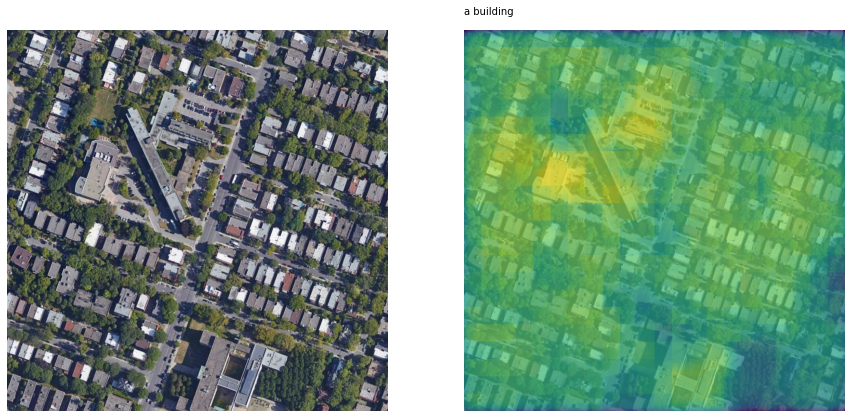

In [4]:
from matplotlib import pyplot as plt

# visualize prediction
_, ax = plt.subplots(1, len(prompts)+1, figsize=(15, 10))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(input_image.resize((*logits.shape[-2:],))) for i in range(len(prompts))];
[ax[i+1].imshow(logits[i,...]-logits[i,...].min(), alpha=0.7) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

### Now, using using positive and negative prompts

In [5]:
input_image = Image.open("../example_earth_high_altitude.jpg").resize((800,800))

positive_prompts = ["a building", 
                    "a house", 
                    "a roof"]
negative_test_prompts = ["a tree", 
                         "a bush",
                         "a vehicle",
                         "a car",
                         "a road"
                        ]
prompts = positive_prompts + negative_test_prompts
inputs = processor(text=prompts, images=[input_image] * len(prompts), padding=True, return_tensors="pt")

for k in inputs:
    inputs[k] = inputs[k].cuda()

In [6]:
%%time
outputs = model(**inputs)

CPU times: user 1.22 s, sys: 21.4 ms, total: 1.24 s
Wall time: 245 ms


In [13]:
use_prob_sum = True # sums the "probs" of all the positive prompts

logits_softmax = outputs.logits.softmax(dim=0)

if use_prob_sum:
    filtered_output = logits_softmax[:len(positive_prompts),...].sum(dim=0)
    filtered_output *= len(negative_test_prompts)/len(positive_prompts)
else:
    filtered_output = logits_softmax[:len(positive_prompts),...].max(dim=0).values

filtered_output = filtered_output.detach().cpu().numpy()

In [14]:
filtered_output -= filtered_output.min()
filtered_output /= filtered_output.max()

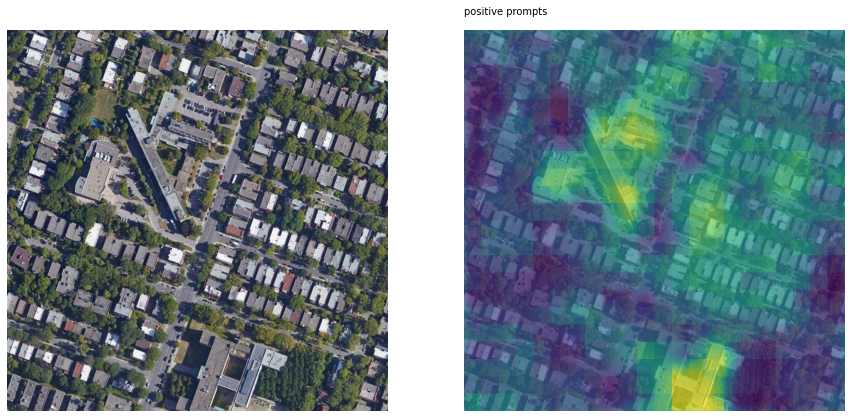

In [15]:
# visualize prediction
_, ax = plt.subplots(1, 2, figsize=(15, 10))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
ax[1].imshow(input_image.resize((*filtered_output.shape[-2:],)));
ax[1].imshow(filtered_output, alpha=0.7)
ax[1].text(0, -15, "positive prompts");